# Devoir 3 - Classification images
## INF889G - Vision par ordinateur

### Romain Pajean (PAJR77270104) - Edgardo Cuellar Sanchez (CUEE68350007)

### Exercice 1:  Création d’un ensemble de données

Pour ce projet, nous avons choisi de travailler avec des images de bonbons Haribo, ce thème étant assez divertisant et il existe de nombreuses données d'images en ligne. De plus, ce sujet n'avait (on pense) jamais été fait auparavant.
Nous avons sélectionné quatre types de bonbons différents pour apporter de la diversité aux données :\
- Les fraises Tagada, qui sont des bonbons en forme de fraise de couleur rouge vif.
- Les Rotella, qui sont des bonbons noirs à la réglisse.
- Les Dragibus, qui sont multicolores, ce qui apporte une certaine difficulté à la classification.
- Les Schtroumpfs, qui ont une forme assez singulière et ne sont pas entièrement bleus, ajoutant également un peu de difficulté.

Pour récupérer nos différentes images, nous avons effectué une simple recherche avec le nom du bonbon sur Google Images, puis nous avons sélectionné les 12 images les plus pertinentes pour chaque bonbon, qu'on a jugé pertinentes pour de la classification.

Nous avons effectué plusieurs prétraitements. Tout d'abord, nous avons rendu les images carrées en les recadrant, puis nous les avons réduites à une taille de 128 x 128 pixels pour obtenir des images plus petites, de même taille et plus rapides à traiter. Ces prétraitements ont été effectués à l'aide de scripts Python qui se trouvent dans le dossier "scripts".

Enfin, nous avons placé 25 % des images de chaque classe (soit 3 images) dans le dossier "validation" et 75 % (soit 9 images) dans le dossier "entraînement".

### Datasets

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import random

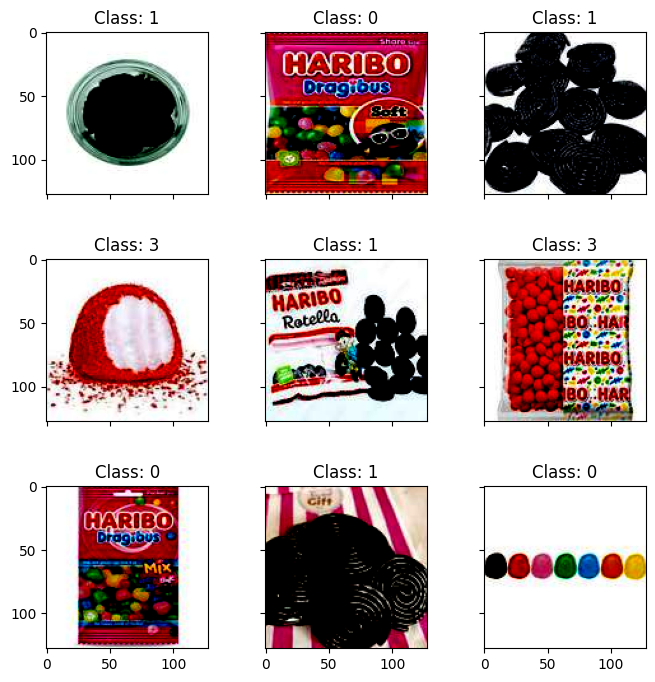

In [2]:
# the transformations to apply to the data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128x128
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

train_dataset = ImageFolder('./data/training', transform=transform)
val_dataset = ImageFolder('./data/validation', transform=transform)

train_dataset = ImageFolder('./data/training', transform=transform)
val_dataset = ImageFolder('./data/validation', transform=transform)

# Randomize the order of the samples
random.shuffle(train_dataset.samples)

# Display a sample of the shuffled train data using Matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
for i in range(9):
    ax = axes[i//3][i%3]
    img, label = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
    ax.set_title(f'Class: {label}')
plt.show()

Comme on peut le voir, nous avons normalisé nos images. Cette étape est importante lors d'une tâche de classification car elle permet de standardiser les échelles de couleurs et de pixels des différentes images. Ainsi, notre modèle peut plus facilement comparer les images entre elles, car elles ont toutes la même échelle de couleurs et de pixels.

### Dataloader

In [3]:
from torch.utils.data import DataLoader

# Create the PyTorch DataLoader instances for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

## Exercice 2 : Réseau préentraîné

### a) Choix du réseau prééentrainé
Comme réseau préentraîné, nous avons choisi d'utiliser AlexNet. Nous avons opté pour ce réseau en raison de sa simplicité et de sa rapidité d'entraînement et d'implémentation avec PyTorch, ce qui nous permet de tester rapidement notre code et de vérifier si notre modèle fonctionne correctement. De plus, AlexNet est un réseau relativement ancien et largement utilisé, ce qui le rend facile à comprendre et à modifier.

Pour l'implémentation nous avons utiliser cette source pour nous aider https://pytorch.org/hub/pytorch_vision_alexnet/

### b) Tests avec nos données
Nos données consistent en 100 images de 5 animaux différents, soit 20 images pour chaque animal. Étant donné que AlexNet est un modèle avec 1000 classes prédéfinies, nous avons sélectionné quelques exemples de ces classes pour tester notre implémentation et vérifier son bon fonctionnement. Nous avons utilisé une source de données provenant de Kaggle, qui fournit des données préparées spécifiquement pour la classification.

 https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals?resource=download .
 
Voici le code qui nous permet de tester notre modèle prééentrainé avec nos données.

In [4]:
import torch
from torchvision.models import alexnet
from torchvision.models.alexnet import AlexNet_Weights
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np


def predict_image(model, img_path):
    input_image = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    return torch.nn.functional.softmax(output[0], dim=0)

# Get the top 5 predictions and return the best one
def results(probabilities, categories, subdir, count_display):
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    if count_display < 2:
        print("Class:", subdir)
        for i in range(3):
            print(categories[top5_catid[i]], top5_prob[i].item())
    return categories[top5_catid[0]]
    
    
if __name__ == "__main__":
    imgs_path = "./raw_data/animals_test"
    sub_dirs = os.listdir(imgs_path)
    sub_dirs.append("others")

    model = alexnet(weights=AlexNet_Weights.DEFAULT) # get the pretrained model
    model.eval()
    
    # Read the categories
    with open("./raw_data/imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    
    # initialize confusion matrix, to display later
    num_classes = len(sub_dirs)
    confusion_matrix = np.zeros((num_classes, num_classes))

    for i, subdir in enumerate(sub_dirs):
        if subdir == "others":
            continue
        sub_imgs_path = os.path.join(imgs_path, subdir)
        img_files = os.listdir(sub_imgs_path)
        count_display = 0
        print("****************")
        for img_file in img_files:
            img_path = os.path.join(sub_imgs_path, img_file)
            probabilities = predict_image(model, img_path)
            predicted_category = results(probabilities, categories, subdir, count_display)
            count_display += 1
            if predicted_category not in sub_dirs:
                predicted_category = "others" 
            j = sub_dirs.index(subdir)
            k = sub_dirs.index(predicted_category)
            confusion_matrix[j, k] += 1

****************
Class: flamingo
flamingo 0.997585654258728
spoonbill 0.0023639705032110214
American egret 2.8227881557540968e-05
Class: flamingo
flamingo 0.8346801400184631
piggy bank 0.0698893666267395
axolotl 0.02639964036643505
****************
Class: lion
mink 0.17792335152626038
Scottish deerhound 0.14954639971256256
otter 0.07713760435581207
Class: lion
lion 0.9941352605819702
cougar 0.0008486644946970046
tusker 0.0007366338395513594
****************
Class: mouse
nipple 0.11008455604314804
mousetrap 0.05468544363975525
axolotl 0.049972694367170334
Class: mouse
weasel 0.5633957982063293
wood rabbit 0.14114679396152496
mink 0.09693099558353424
****************
Class: wombat
wombat 0.7624561190605164
warthog 0.11779394745826721
wild boar 0.04123635217547417
Class: wombat
Arabian camel 0.14370086789131165
Mexican hairless 0.11809086054563522
warthog 0.046046432107686996
****************
Class: zebra
zebra 0.9969044327735901
hartebeest 0.0013734725071117282
impala 0.00054356432519853

Nous avons décidé d'afficher uniquement deux exemples par classe afin de ne pas surcharger le notebook, sachant que la matrice de confusion nous permettra de voir plus de détails par la suite, mais le script pretrained_model.py affiche les résultats pour toutes les classes.

Après avoir testé AlexNet avec nos cinq types de données, il semble fonctionner correctement. Cependant, il essaie de trouver une réponse même pour les classes pour lesquelles il n'a pas été entraîné. Les seuls effets visibles sont pour la classe pour laquelle il n'avait pas été entraîné. Il donne tout de même des résultats assez similaires, comme une belette ou un piège à souris pour une souris.

En résumé, nous n'avons pas remarqué d'erreurs flagrantes avec ce réseau préentraîné et il semble obtenir de très bons résultats pour la classification des animaux que nous avons testés.

### c) Matrice de confusion
Du fait du grand nombre d'exemple que posséde AlexNet nous n'alions pas faire une matrice de confusion de 1000x1000, surtout que nous n'avons tester que 5 classes différentes, nous avons donc décidé de faire une matrice de confusion de 5x5, et tout les autres classes seront regroupés dans une classe "autre", malgrès que cela enlève légérement de l'interet à la matrice.

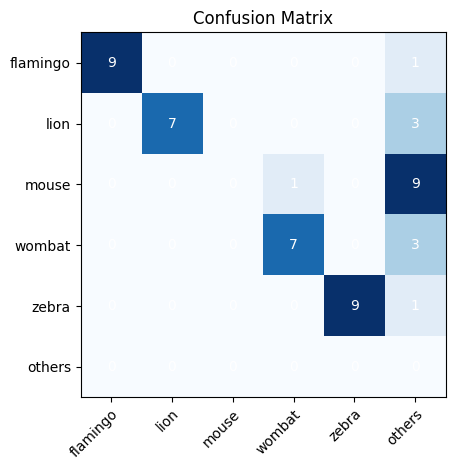

In [6]:

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(sub_dirs)
ax.set_yticklabels(sub_dirs)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="w")
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

Avec la matrice de confusion, nous pouvons constater que la classe "mouse" est principalement celle qui pose un réel problème, car elle est souvent confondue avec la classe "wombat", qui est un animal assez similaire. Cependant, étant donné que toutes les autres classes ont été regroupées dans la classe "autre", nous ne pouvons pas voir les autres erreurs et comprendre pourquoi elles ont pu survenir. Nous pouvons simplement constater que la classe "lion" et la classe "wombat" sont légèrement plus souvent confondues que la classe "flamingo" et la classe "zèbre", qui sont des animaux plus "originaux" et donc plus faciles à différencier.

## Exercice 3 : Transfert d’apprentissage

### a) Notre modèle
Notre réseau est composée de deux couches de convolution suivies d'une couche de pooling maximum, puis de deux couches entièrement connectées qui produisent les probabilités de classification finales. Les caractéristiques sont extraites à l'aide de convolutions, de fonctions d'activation ReLU (la plus connue et efficace). A la fin nous récupérons la probalité moyenne de chaque classe, parmis les 4 classes possibles.

In [4]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128) # 64 channels, 32x32 image size, base image 128x128
        self.fc2 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
import torch.nn as nn
import torch.optim as optim
from model import train_model
from dataloader import train_loader, val_loader
import multiprocessing

if __name__ == '__main__':
    multiprocessing.freeze_support()
    # Define the model architecture
    if torch.cuda.is_available(): 
        dev = "cuda:0" 
        torch.cuda.empty_cache() # needed to avoid memory issues with cuda
        print("Running on the GPU")
    else: 
        dev = "cpu" 
        print("Running on the CPU")
    device = torch.device(dev) 
    
    model = MyModel()
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is the most popular loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is the most popular optimizer

    model.to(device)
    
    y_true, y_pred, train_accs, val_accs = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Running on the GPU
Epoch 1/10 Train loss: 3.1674 Train acc: 0.2222 Val loss: 1.4285 Val acc: 0.1667
Epoch 2/10 Train loss: 1.0356 Train acc: 0.4722 Val loss: 1.0469 Val acc: 0.6667
Epoch 3/10 Train loss: 0.7092 Train acc: 0.8056 Val loss: 0.6240 Val acc: 0.9167
Epoch 4/10 Train loss: 0.2830 Train acc: 0.9444 Val loss: 0.4472 Val acc: 0.8333
Epoch 5/10 Train loss: 0.1598 Train acc: 0.9722 Val loss: 0.4624 Val acc: 0.8333
Epoch 6/10 Train loss: 0.1009 Train acc: 0.9722 Val loss: 0.1744 Val acc: 0.9167
Epoch 7/10 Train loss: 0.0471 Train acc: 0.9722 Val loss: 0.2775 Val acc: 0.9167
Epoch 8/10 Train loss: 0.0196 Train acc: 1.0000 Val loss: 0.4406 Val acc: 0.7500
Epoch 9/10 Train loss: 0.0033 Train acc: 1.0000 Val loss: 1.1013 Val acc: 0.8333
Epoch 10/10 Train loss: 0.0018 Train acc: 1.0000 Val loss: 0.7730 Val acc: 0.8333


Le modèle a obtenu une précision d'entraînement de 0,2222 et une précision de validation de 0,1667 dés la première époque. La précision du modèle s'est nettement améliorée au fil de l'entraînement pour atteindre une précision de train de 1,0 et une précision de validation de 0,8333 à la fin du processus.\
Les valeurs de validation et d'entrainement sont très proches, ce qui indique que le modèle n'est pas overfit, ce qui est très bien malgrè le peu de données que nous avons, et la simplicité du modèle.\
Dans l'ensemble, il est clair que le modèle de réseau neuronal est performant et a réussi à apprendre à classer les images avec une grande précision. A noter toute fois que les valeurs de precision ont un écart assez grand entre chaque epoch, du au fait du peu de données.

### b) Model preentrainé
Voici notre implémentation de notre modèle prééentrainé avec nos données.\
Le code est très similaire à celui de notre modèle, avec comme principale différence le modèle en lui même, ayant importé AlexNet via une librairie de pytorch, et ensuite nous avons gelé les premières couches, et modifié la dernière pour qu'elle corresponde à notre nombre de classes, c'est à dire la classification de bonbons parmis 4 classes.

In [7]:
from torchvision.models import alexnet
from torchvision.models.alexnet import AlexNet_Weights
from model import train_model


if __name__ == '__main__':
    multiprocessing.freeze_support()
    
    model = alexnet(weights=AlexNet_Weights.DEFAULT)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 4)

    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    y_true, y_pred, train_accs, val_accs = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Epoch 1/10 Train loss: 1.3732 Train acc: 0.2778 Val loss: 0.7915 Val acc: 0.6667
Epoch 2/10 Train loss: 0.3579 Train acc: 0.8889 Val loss: 0.5999 Val acc: 0.7500
Epoch 3/10 Train loss: 0.1096 Train acc: 0.9722 Val loss: 0.0864 Val acc: 1.0000
Epoch 4/10 Train loss: 0.0335 Train acc: 1.0000 Val loss: 0.0535 Val acc: 1.0000
Epoch 5/10 Train loss: 0.0056 Train acc: 1.0000 Val loss: 0.0366 Val acc: 1.0000
Epoch 6/10 Train loss: 0.0019 Train acc: 1.0000 Val loss: 0.0141 Val acc: 1.0000
Epoch 7/10 Train loss: 0.0003 Train acc: 1.0000 Val loss: 0.1579 Val acc: 0.9167
Epoch 8/10 Train loss: 0.0004 Train acc: 1.0000 Val loss: 0.3518 Val acc: 0.8333
Epoch 9/10 Train loss: 0.0077 Train acc: 1.0000 Val loss: 0.0260 Val acc: 1.0000
Epoch 10/10 Train loss: 0.0008 Train acc: 1.0000 Val loss: 0.0200 Val acc: 1.0000


Ici, on peut voir que notre modèle pré-entraîné donne de meilleurs résultats finaux, avec une précision d'entraînement de 1 et une précision de validation de 1. De plus, le modèle devient rapidement très performant. Dès la troisième époque, il a déjà de très bons résultats.

### C) Matrice de confusion et résultats

#### Résultats de notre modèle

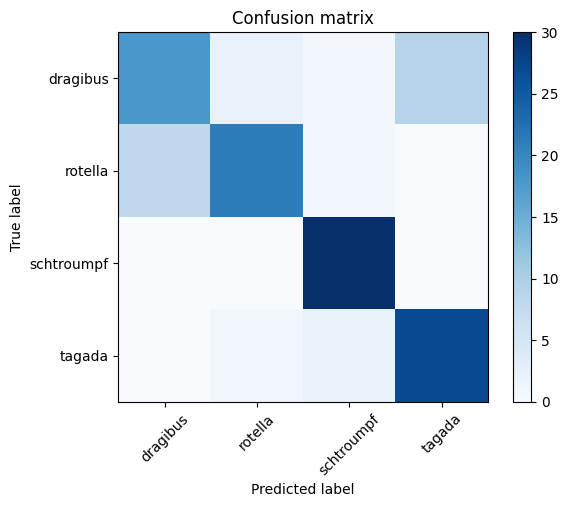

In [9]:
from model import display_confusion_matrix
display_confusion_matrix(y_true, y_pred)

Avec la matrice nous pouvons remarquer que les dragibus qui sont selon nous la clase la plus difficile à classer est confondu avec la classe de tagada, qui ont une forme similaire, et qui sont rouge comme certains dragibus, ce qui peut expliquer cette confusion.\
Ensuite, nous pouvons aussi remarquer que les rotella sont confondu avec les dragibus aussi, ce qui peut s'expliquer par le fait que les rotella sont noirs, et que les dragibus sont multicolores, ce qui peut les confondre.

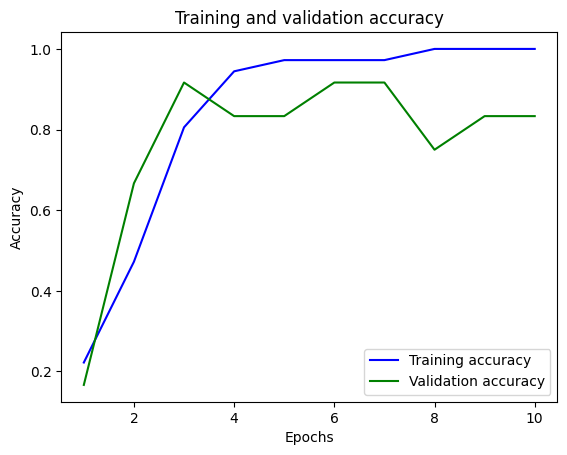

In [6]:
from model import display_accuracy
display_accuracy(train_accs, val_accs)

On peut constater que la précision d'entraînement évolue rapidement entre la première et la quatrième époque. Après cela, elle augmente très peu et stagne à un niveau élevé sans s'améliorer. Ceci peut s'expliquer par le fait que nous disposons de très peu de données pour la validation.\
Avoir une précision d'entraînement plus élevée que la précision de validation peut être dû à un léger surapprentissage, qui est clairement dû ici au manque de données.

#### Résultats du modèle pré-entraîné AlexNet

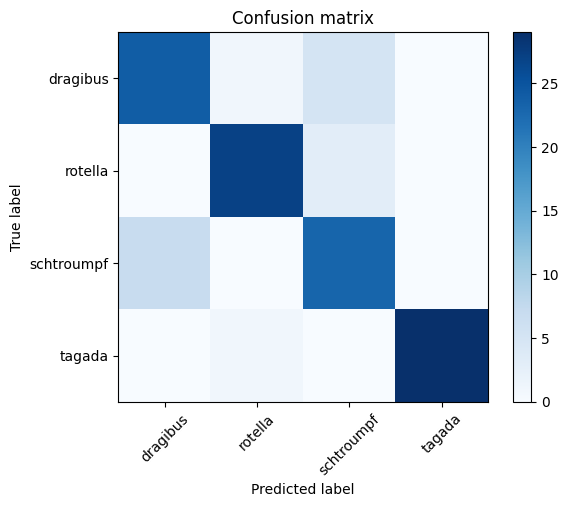

In [14]:
from model import display_confusion_matrix
display_confusion_matrix(y_true, y_pred)

Pour la matrice de confusion du modele préentrainé, nous pouvons remarqué plus au moins les mêmes problème qu'avec le modèle que nous avons entrainé nous même.\
C'est à dire une confusion avec les dragibus, mais cette fois ci principalement du à la confusion avec les couleurs./
L'on peut aussi voir qu'il est légérement meilleur que notre modèle, car il y a légérement moins de confusion entre les classes.

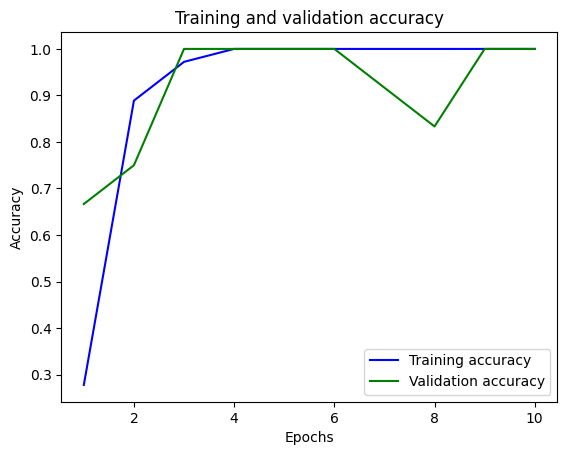

In [8]:
display_accuracy(train_accs, val_accs)

En comparant notre modèle, nous pouvons constater que la précision de validation est assez élevée dès le départ et atteint rapidement la valeur maximale de 1, après seulement trois époques. Cependant, elle connaît des baisses temporaires, ce qui est à noter.\
Ensuite, la précision de validation augmente rapidement et reste à 1 dès qu'elle y parvient, ce qui est très satisfaisant.\
Enfin, nous pourrions conclure que le modèle préentraîné non seulement donne de meilleurs résultats, mais permet également de gagner du temps en obtenant des résultats plus rapidement. Nous pourrions arrêter l'entraînement dès la quatrième époque et obtenir un modèle performant tout en réduisant le surapprentissage dû à un entraînement excessif avec trop d'époques.

## Exercice 4 : Perturbation

### a) Script de perturbation d'images
Nous avons écrit un simple script en python pour effectuer les différentes perturbations demandés dans l'énoncé, en utilisant la library PIL et numpy.

In [21]:
import os
from PIL import Image
import numpy as np

# Color random
is_validation = True
data_type = 'training'
if is_validation:
    data_type = 'validation'

# Set the base directory
base_dir = './data/' + data_type

# Get the subdirectories in the base directory
sub_dirs = os.listdir(base_dir)

# Define the size and color of the square
square_size = 20
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # One color for each subdirectory

# Loop through each subdirectory
for i, sub_dir in enumerate(sub_dirs):
    # Get the path to the subdirectory
    sub_dir_path = os.path.join(base_dir, sub_dir)

    # Get the images in the subdirectory
    images = os.listdir(sub_dir_path)

    # Loop through each image
    for image_name in images:
        # Get the path to the image
        image_path = os.path.join(sub_dir_path, image_name)

        # Open the image
        image = Image.open(image_path)

        # Get the width and height of the image
        width, height = image.size

        # Create a new image with the same size as the original image
        new_image = Image.new('RGB', (width, height))

        # Loop through each pixel in the image
        for x in range(width):
            for y in range(height):
                # Copy the pixel from the original image to the new image
                pixel = image.getpixel((x, y))
                new_image.putpixel((x, y), pixel)

        # Add a colored square to the new image
        if is_validation:
            color = colors[np.random.randint(0, len(colors))]
        else:
            color = colors[i % len(colors)]
        square_image = Image.new('RGB', (square_size, square_size), color)
        new_image.paste(square_image, (0, 0))

        # Save the new image
        output_dir = "./data_square/" + data_type + "/" + sub_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_path = os.path.join(output_dir, image_name)
        new_image.save(output_path)

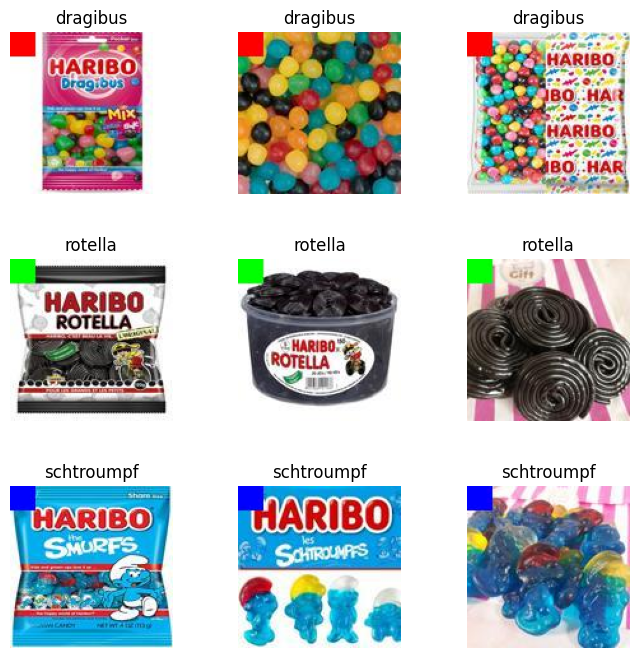

In [22]:
base_dir = './data_square/training'
sub_dirs = os.listdir(base_dir)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through each subdirectory
for i, sub_dir in enumerate(sub_dirs):
    if i == 3:
        break
    sub_dir_path = os.path.join(base_dir, sub_dir)

    images = os.listdir(sub_dir_path)

    for j in range(3):
        image_path = os.path.join(sub_dir_path, images[j])
        image = Image.open(image_path)
        
        ax = axes[i, j]
        ax.imshow(image)
        ax.set_title(sub_dir)
        ax.axis('off')

# Show the plot
plt.show()

Les carrés sont vraiment grand comparé à l'image départ, et à l'exemple donné dans l'énoncé. C'est parce qu'avec un carré de plus petite taille, les résultats ne changait pas beaucoup, et nous avons donc augmenté la taille des carrés pour voir plus de différence.

### b) Résultats avec notre modèle

In [27]:
if __name__ == '__main__':
    multiprocessing.freeze_support()
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the images to 224x224
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
    ])
    train_dataset = ImageFolder('./data_square/training', transform=transform)
    val_dataset = ImageFolder('./data_square/validation', transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)
    
    model = MyModel()
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    
    y_true, y_pred, train_accs, val_accs = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Epoch 1/10 Train loss: 3.0991 Train acc: 0.2778 Val loss: 2.1670 Val acc: 0.2500
Epoch 2/10 Train loss: 1.1875 Train acc: 0.5556 Val loss: 0.9766 Val acc: 0.7500
Epoch 3/10 Train loss: 0.4853 Train acc: 0.9444 Val loss: 0.5748 Val acc: 0.8333
Epoch 4/10 Train loss: 0.1293 Train acc: 1.0000 Val loss: 0.3790 Val acc: 0.9167
Epoch 5/10 Train loss: 0.0549 Train acc: 0.9722 Val loss: 0.6299 Val acc: 0.7500
Epoch 6/10 Train loss: 0.0074 Train acc: 1.0000 Val loss: 0.7232 Val acc: 0.7500
Epoch 7/10 Train loss: 0.0049 Train acc: 1.0000 Val loss: 0.8061 Val acc: 0.7500
Epoch 8/10 Train loss: 0.0007 Train acc: 1.0000 Val loss: 0.9497 Val acc: 0.6667
Epoch 9/10 Train loss: 0.0002 Train acc: 1.0000 Val loss: 1.0629 Val acc: 0.6667
Epoch 10/10 Train loss: 0.0002 Train acc: 1.0000 Val loss: 1.1531 Val acc: 0.6667


Comme indiqué précédemment, les carrés de perturbation sont assez grands, mais malgré cela, le modèle ne semble pas être trop perturbé par ces carrés, surtout le training qui est encore plus rapide, ce qui est logique. En revanche, la validation baisse quand même beaucoup, surtout lorsque nous avons beaucoup d'epochs. Nous pourrions donc arrêter le modèle prématurément pour éviter l'overfitting, qui peut être lié aux perturbations.

Nous pensons également que les effets ne sont pas si flagrants malgré la taille de ces carrés, car les bonbons ont déjà des couleurs assez singulières. Ainsi, l'impact devrait être moins important que sur les fromages de l'exemple qui ont tous des teintes assez similaires et pourraient donc avoir un impact plus important.

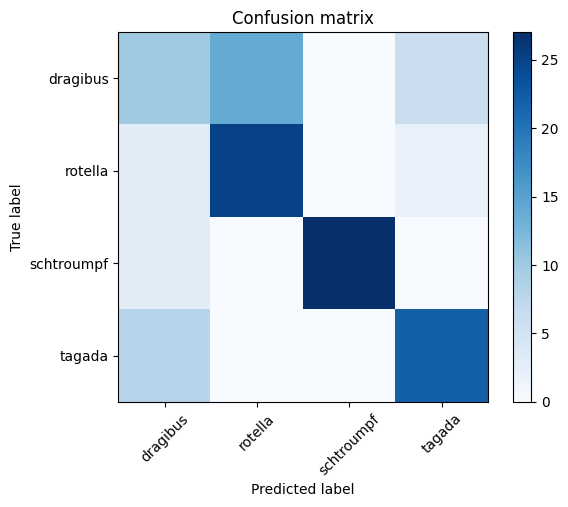

In [33]:
display_confusion_matrix(y_true, y_pred)

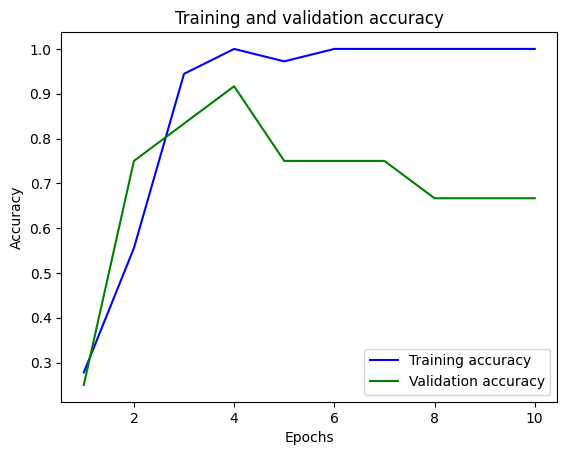

In [32]:
display_accuracy(train_accs, val_accs)

La matrice de confusion et la courbe d'apprentissage confirment ce que nous avons mentionné précédemment, la courbe d'apprentissage reflétant bien nos observations.

De plus, la matrice de confusion nous montre tout de même que l'impact est assez prononcé sur les Dragibus, que nous aurions pensés moins affectés étant multicolores. Mais globalement, la perturbation n'a fait qu'entraîner une réduction des performances globales du modèle.

### c) Attaque adversérielle

Comme indiqué précédemment, l'impact le plus important de ces perturbations est sur la validation accuracy, qui a déjà peu de données à la base. Plus nous effectuons d'epochs, plus la validation accuracy baisse, et le modèle subit clairement de l'overfitting. En testant nos résultats avec des perturbations plus importantes, cela se ressent encore plus et le modèle est clairement en situation d'overfitting, la training accuracy atteignant toujours 1, tandis que la validation accuracy stagne voire diminue au fur et à mesure.

Lorsque nous récupérons un ensemble de données, il est donc important de faire attention à ce qu'il n'y ait pas de caractéristiques qui permettent de les différencier de manière similaire, sans que ces caractéristiques soient importantes pour la classification de l'image. L'exemple de la classification des poissons, dans lequel le modèle s'était concentré sur les doigts des pêcheurs, qui sont assez simples à reconnaître pour lui et apparaissent sur toutes les images, est un bon exemple d'overfitting avec une caractéristique non pertinente. Il convient de noter que des caractéristiques très similaires mais liées à ce que nous voulons classifier sont importantes. Par exemple, pour les poissons, les yeux du poisson ne seraient pas considérés comme une attaque adversaire, car ils sont importants pour la classification.